# Approche DnCNN pour le debruitage d'images

## Chargement du fichier de données

In [ ]:
import gc
import tensorflow as tf
import torch
from google.colab import files
#


gc.collect()
#Pour l'utilisation du GPU, vous pouvez également essayer :
!nvidia-smi
#Si vous utilisez TensorFlow :
tf.keras.backend.clear_session()
#Si vous utilisez PyTorch :
torch.cuda.empty_cache()


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## Dézipper les données

In [1]:

import zipfile
uploaded = "/content/flickr_images.zip"
if uploaded.endswith('.zip'):
    zip_ref = zipfile.ZipFile(uploaded, 'r')
    zip_ref.extractall('/content/')
    zip_ref.close()
    print(f"File '{uploaded}' unzipped successfully to /content/")
else:
    print(f"File '{uploaded}' is not a zip file.")


File '/content/flickr_images.zip' unzipped successfully to /content/


## Préparation des données

Processing images for /content/data/div2k_noisy_dataset/train/clean: 100%|██████████| 1818/1818 [00:42<00:00, 42.68it/s]
Processing images for /content/data/div2k_noisy_dataset/val/clean: 100%|██████████| 227/227 [00:05<00:00, 42.90it/s]
Processing images for /content/data/div2k_noisy_dataset/test/clean: 100%|██████████| 227/227 [00:05<00:00, 42.88it/s]


Training images: 1818
Validation images: 227
Test images: 227


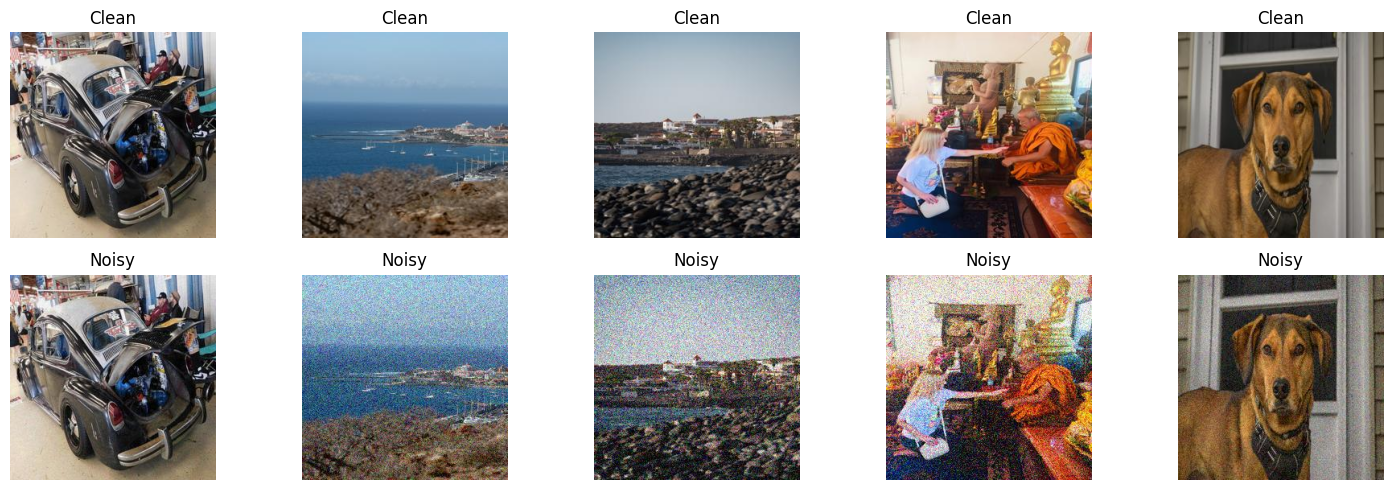

In [2]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
IMAGE_SIZE = (256, 256)
TRAIN_SIZE = 1818
VAL_SIZE = 227
TEST_SIZE = 227

# Chemins d’accès à l’organisation des ensembles de données
BASE_DIR = "/content/data/div2k_noisy_dataset"
DIRS = {
    "train_clean": os.path.join(BASE_DIR, "train/clean"),
    "train_noisy": os.path.join(BASE_DIR, "train/noisy"),
    "val_clean": os.path.join(BASE_DIR, "val/clean"),
    "val_noisy": os.path.join(BASE_DIR, "val/noisy"),
    "test_clean": os.path.join(BASE_DIR, "test/clean"),
    "test_noisy": os.path.join(BASE_DIR, "test/noisy"),
}

# Function to create directories
def create_directories(dirs):
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)

# Ajout de bruit avec des niveaux aléatoires
def prepare_images_with_varied_noise(base_images, num_images, clean_dir, noisy_dir, noise_stddev_range):
    selected_images = np.random.choice(base_images, num_images, replace=False)
    for img_path in tqdm(selected_images, desc=f"Processing images for {clean_dir}"):
        img = Image.open(img_path).convert("RGB").resize(IMAGE_SIZE)
        clean_img = np.asarray(img, dtype=np.float32) / 255.0

        # Niveau de bruit aléatoire
        noise_stddev = np.random.uniform(noise_stddev_range[0], noise_stddev_range[1])
        noise = np.random.normal(0, noise_stddev / 255.0, clean_img.shape)
        noisy_img = np.clip(clean_img + noise, 0.0, 1.0)

        # Sauvegarde
        clean_file_path = os.path.join(clean_dir, os.path.basename(img_path))
        noisy_file_path = os.path.join(noisy_dir, os.path.basename(img_path))
        Image.fromarray((clean_img * 255).astype(np.uint8)).save(clean_file_path)
        Image.fromarray((noisy_img * 255).astype(np.uint8)).save(noisy_file_path)


# Main process
def process_dataset():
    div2k_path = "/content/flickr_images"
    all_images = [os.path.join(div2k_path, f) for f in os.listdir(div2k_path) if f.endswith(".jpg")]

    # Split dataset
    train_images, temp_images = train_test_split(all_images, train_size=TRAIN_SIZE)
    val_images, test_images = train_test_split(temp_images, test_size=TEST_SIZE, train_size=VAL_SIZE)

    # Creation des répertoires
    create_directories(DIRS)

    # Traiter et enregistrer des images
    prepare_images_with_varied_noise(train_images, TRAIN_SIZE, DIRS["train_clean"], DIRS["train_noisy"], (5, 50))
    prepare_images_with_varied_noise(val_images, VAL_SIZE, DIRS["val_clean"], DIRS["val_noisy"], (5, 50))
    prepare_images_with_varied_noise(test_images, TEST_SIZE, DIRS["test_clean"], DIRS["test_noisy"], (5, 50))




    print(f"Training images: {len(os.listdir(DIRS['train_clean']))}")
    print(f"Validation images: {len(os.listdir(DIRS['val_clean']))}")
    print(f"Test images: {len(os.listdir(DIRS['test_clean']))}")

# Run the process
process_dataset()

# Afficher quelques exemples
def display_examples(clean_dir, noisy_dir, num_examples=5):
    clean_images = os.listdir(clean_dir)[:num_examples]
    noisy_images = os.listdir(noisy_dir)[:num_examples]

    plt.figure(figsize=(15, 5))
    for i, (clean_img, noisy_img) in enumerate(zip(clean_images, noisy_images)):
        clean_path = os.path.join(clean_dir, clean_img)
        noisy_path = os.path.join(noisy_dir, noisy_img)

        clean = np.array(Image.open(clean_path))
        noisy = np.array(Image.open(noisy_path))

        plt.subplot(2, num_examples, i + 1)
        plt.imshow(clean)
        plt.title("Clean")
        plt.axis("off")

        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(noisy)
        plt.title("Noisy")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display examples from training set
display_examples(DIRS["train_clean"], DIRS["train_noisy"])

## Definition du model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Définition du modèle DnCNN
class DnCNN(nn.Module):
    def __init__(self, num_layers=20, num_filters=64, activation=nn.ReLU(inplace=True)):
        super(DnCNN, self).__init__()
        layers = []

        # Première couche convolutive
        layers.append(nn.Conv2d(3, num_filters, kernel_size=3, padding=1, bias=False))
        layers.append(activation)

        # Couches intermédiaires
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(activation)

        # Dernière couche convolutive
        layers.append(nn.Conv2d(num_filters, 3, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

# Instancier le modèle
num_layers = 20
num_filters = 64
model = DnCNN(num_layers=num_layers, num_filters=num_filters)

# Fonction de perte et optimiseur
criterion = nn.MSELoss()  # Utilisation de MSE comme fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Initialisation des métriques PSNR
def psnr(clean, noisy):
    mse = torch.mean((clean - noisy) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# Compilation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

print("Modèle construit et prêt pour l'entraînement.")


Modèle construit et prêt pour l'entraînement.


## Préparation et lancement de l'entraînement

Epoch [1/50], Train Loss: 0.0020, Train PSNR: 27.03 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [2/50], Train Loss: 0.0020, Train PSNR: 27.02 dB, Val Loss: 0.0017, Val PSNR: 27.81 dB
Epoch [3/50], Train Loss: 0.0020, Train PSNR: 27.04 dB, Val Loss: 0.0017, Val PSNR: 27.80 dB
Epoch [4/50], Train Loss: 0.0020, Train PSNR: 27.01 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [5/50], Train Loss: 0.0020, Train PSNR: 27.04 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [6/50], Train Loss: 0.0020, Train PSNR: 27.01 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [7/50], Train Loss: 0.0020, Train PSNR: 27.03 dB, Val Loss: 0.0017, Val PSNR: 27.78 dB
Epoch [8/50], Train Loss: 0.0020, Train PSNR: 27.02 dB, Val Loss: 0.0017, Val PSNR: 27.81 dB
Epoch [9/50], Train Loss: 0.0020, Train PSNR: 27.02 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [10/50], Train Loss: 0.0020, Train PSNR: 27.02 dB, Val Loss: 0.0017, Val PSNR: 27.79 dB
Epoch [11/50], Train Loss: 0.0020, Train PSNR: 27.02 dB, Val Loss: 0.

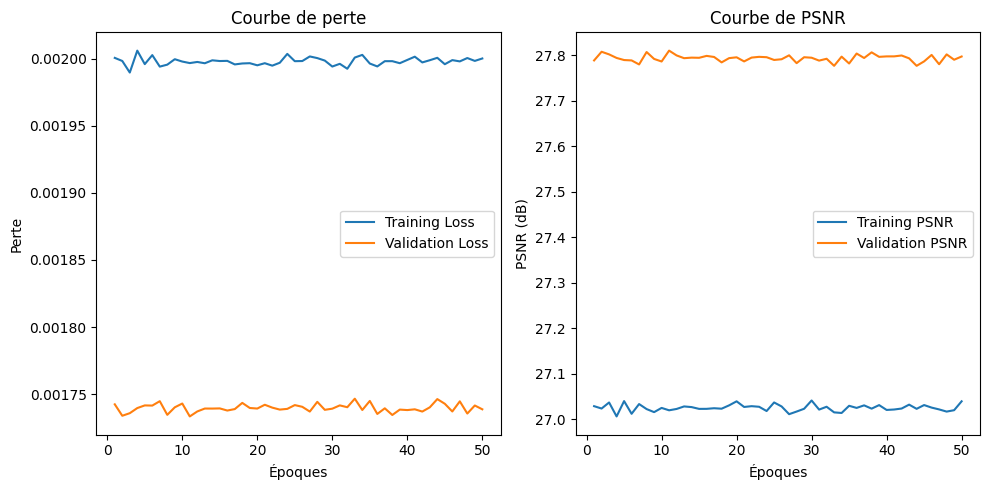

In [8]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt


# Dataset personnalisé pour charger les images propres et bruitées
class DenoisingDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, transform=None):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.clean_images = os.listdir(clean_dir)
        self.noisy_images = os.listdir(noisy_dir)
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_path = os.path.join(self.clean_dir, self.clean_images[idx])
        noisy_path = os.path.join(self.noisy_dir, self.noisy_images[idx])

        clean_img = Image.open(clean_path).convert("RGB")
        noisy_img = Image.open(noisy_path).convert("RGB")

        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)

        return noisy_img, clean_img

# Transformation pour les images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Charger les données
train_dataset = DenoisingDataset(
    clean_dir="/content/data/div2k_noisy_dataset/train/clean",
    noisy_dir="/content/data/div2k_noisy_dataset/train/noisy",
    transform=transform
)
val_dataset=DenoisingDataset(
    clean_dir="/content/data/div2k_noisy_dataset/val/clean",
    noisy_dir="/content/data/div2k_noisy_dataset/val/noisy",
    transform=transform
)

# Creation des data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)




# Fonction d'entraînement
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device="cpu", save_path="dncnn_model.pth"):
    model.train()
    train_losses = []
    train_psnrs = []
    val_losses = []
    val_psnrs = []

    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_train_psnr = 0.0
    best_val_psnr = 0.0

    for epoch in range(num_epochs):
        # --- Training phase ---
        model.train()
        epoch_train_loss = 0
        epoch_train_psnr = 0

        for noisy_imgs, clean_imgs in train_loader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_psnr += psnr(outputs, clean_imgs).item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_psnr = epoch_train_psnr / len(train_loader)
        train_losses.append(avg_train_loss)
        train_psnrs.append(avg_train_psnr)

        # Mettre à jour les meilleures mesures d'entraînement si l'époque actuelle est meilleure
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
        if avg_train_psnr > best_train_psnr:
            best_train_psnr = avg_train_psnr

        # ---phase de Validation  ---
        model.eval()
        epoch_val_loss = 0
        epoch_val_psnr = 0

        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs = noisy_imgs.to(device)
                clean_imgs = clean_imgs.to(device)

                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)

                epoch_val_loss += loss.item()
                epoch_val_psnr += psnr(outputs, clean_imgs).item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_psnr = epoch_val_psnr / len(val_loader)
        val_losses.append(avg_val_loss)
        val_psnrs.append(avg_val_psnr)

         # Mettre à jour les meilleures mesures de validation si l'époque actuelle est meilleure
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        if avg_val_psnr > best_val_psnr:
            best_val_psnr = avg_val_psnr

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f} dB, "
              f"Val Loss: {avg_val_loss:.4f}, Val PSNR: {avg_val_psnr:.2f} dB")

        # Enregistrez le modèle si la perte de validation s'améliore
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path} (best validation loss)")


    # Imprimer les meilleures mesures après la formation
    print(f"\nBest Training Loss: {best_train_loss:.4f}, Best Training PSNR: {best_train_psnr:.2f} dB")
    print(f"Best Validation Loss: {best_val_loss:.4f}, Best Validation PSNR: {best_val_psnr:.2f} dB")

  # Sauvegarde du modèle
    torch.save(model.state_dict(), save_path)
    print(f"Modèle sauvegardé dans {save_path}")

    # Visualisation des courbes
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.title("Courbe de perte")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_psnrs, label="Training PSNR")
    plt.plot(range(1, num_epochs + 1), val_psnrs, label="Validation PSNR")
    plt.xlabel("Époques")
    plt.ylabel("PSNR (dB)")
    plt.title("Courbe de PSNR")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Lancer l'entraînement avec sauvegarde et graphiques
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device,
)



## Chargement du modèle déjà entraîné

In [5]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import numpy as np


# Charger le modèle entraîné
model_path = '/content/dncnn_model.pth'  # Remplacez par le chemin réel du modèle
model = DnCNN(num_layers=20, num_filters=64)
model.load_state_dict(torch.load(model_path))
model.eval()  #passer le modèle en mode évaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<ipython-input-5-63dc4cfd9e88>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## Tester le modèle

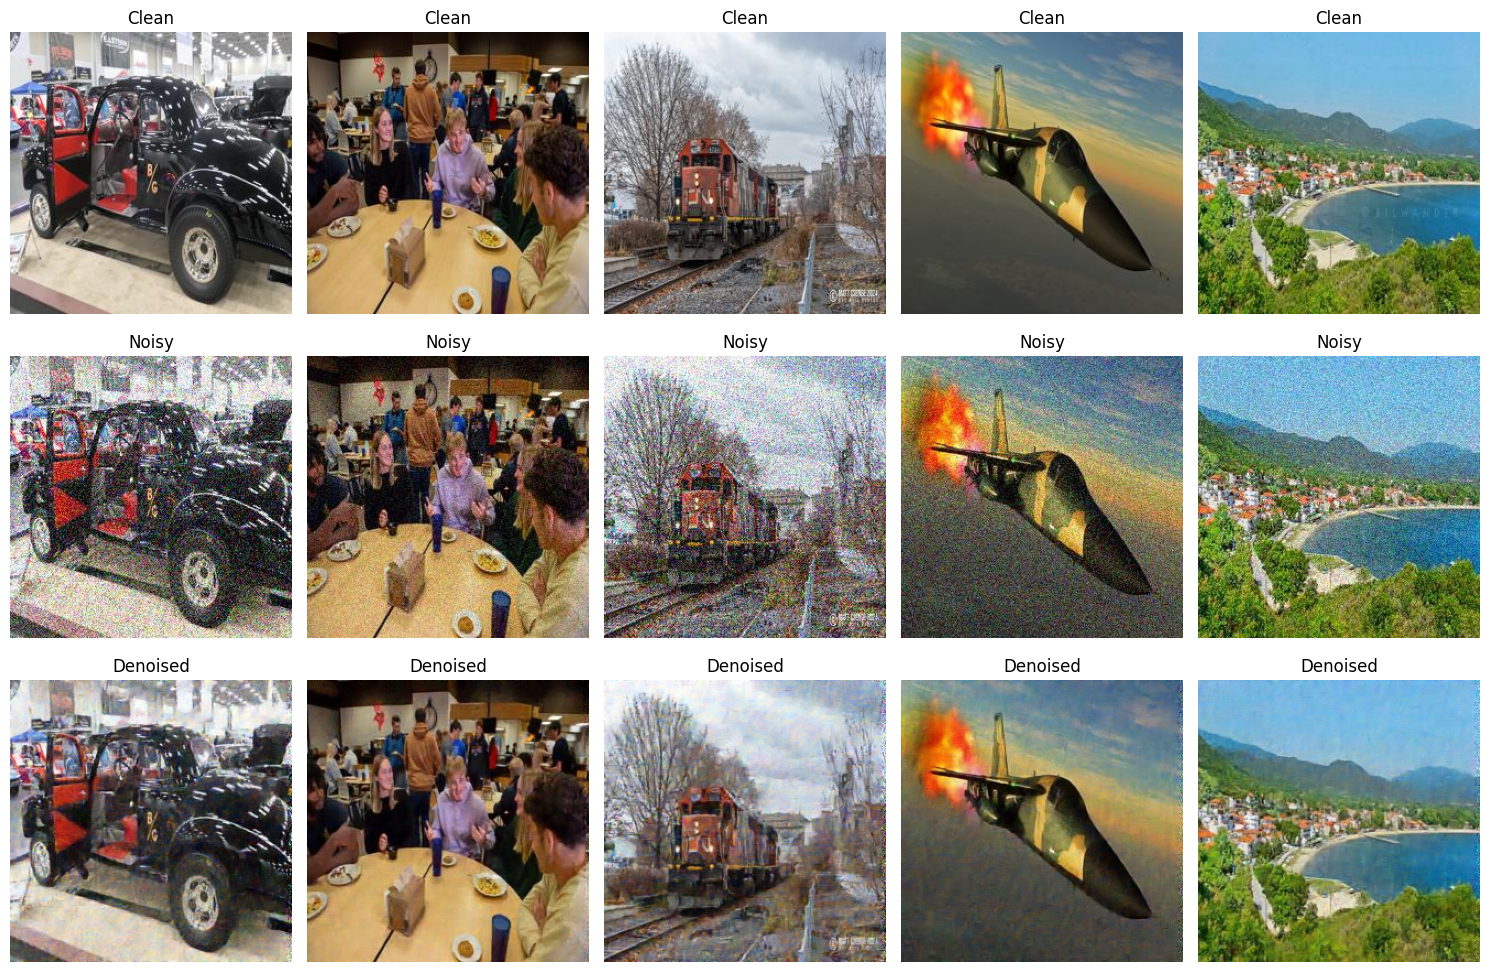

In [9]:
# Fonction pour tester le modèle
def test_model(model, clean_dir, noisy_dir, device, num_examples=5):
    transform = transforms.Compose([transforms.ToTensor()])

    clean_images = os.listdir(clean_dir)[:num_examples]
    noisy_images = os.listdir(noisy_dir)[:num_examples]

    plt.figure(figsize=(15, 10))

    for i, (clean_img_name, noisy_img_name) in enumerate(zip(clean_images, noisy_images)):
        clean_path = os.path.join(clean_dir, clean_img_name)
        noisy_path = os.path.join(noisy_dir, noisy_img_name)

        noisy_img = Image.open(noisy_path).convert("RGB")
        noisy_img = transform(noisy_img).unsqueeze(0).to(device)

        with torch.no_grad():
            denoised_img = model(noisy_img)

        denoised_img = denoised_img.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
        denoised_img = np.clip(denoised_img, 0, 1)  # Assurez-vous que les valeurs sont dans [0, 1]


        # Afficher les images
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(np.array(Image.open(clean_path)))
        plt.title("Clean")
        plt.axis("off")

        plt.subplot(3, num_examples, i + 1 + num_examples)
        plt.imshow(np.array(Image.open(noisy_path)))
        plt.title("Noisy")
        plt.axis("off")

        plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
        plt.imshow(denoised_img)
        plt.title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Tester le modèle
test_model(model, DIRS["test_clean"], DIRS["test_noisy"], device)